# Deflection by an extended mass distribution

In this application, we implement the calculation of the deflection angle field by an extended lens. A two-dimensional map of the lens surface-density is contained the ```data``` folder and it is called ```kappa_2.fits```. To be precise, this is the surface density divided by a constant which depends on the lens and source redshifts (we will talk about this constant in the next lectures). Let's denote this quantity as $\kappa$. Accounting for this normalization, the calulation we want to implement is
$$
\vec\alpha(\vec x)=\frac{1}{\pi}\int\kappa(\vec x')\frac{\vec x-\vec x'}{|\vec x-\vec x'|^2}d^2 x' \;.
$$
This is a convolution, which can be written in the Fourier Space as
$$
\vec{\tilde\alpha}(\vec k)=2\pi \tilde\kappa (\vec k) \vec{\tilde K} (\vec k)
$$
where  $\vec{\tilde{K}}(\vec{k})$ is the Fourier Transform of
$$
\vec{K}(\vec x)=\frac{1}{\pi}\frac{\vec{x}}{|\vec{x}|^2}
$$

To implement this calculation, we use the ```numpy.fft``` module.

In [1]:
import numpy as np
import numpy.fft as fftengine

We define a class called deflector, where the deflector object is initialized throught a fits file containing the surface density map of the lens.
To deal with the fits files, we need to use the ```astropy.io.fits``` module.

The class contains some methods to
* build the kernel $K(\vec{x})$
* compute the deflection angle map by convolving the convergence with the kernel
* perform the so-called "zero-padding"

In [2]:
import astropy.io.fits as pyfits  # Import the FITS file handling module from astropy

class deflector(object):  # Define the class 'deflector'

    # Initialize the deflector with a surface density map
    def __init__(self, filekappa, pad=False):
        kappa, header = pyfits.getdata(filekappa, header=True)  # Load the kappa (convergence) data and header from a FITS file
        self.kappa = kappa  # Store the kappa map in the class instance
        self.nx = kappa.shape[0]  # Store the x-dimension of the kappa map
        self.ny = kappa.shape[1]  # Store the y-dimension of the kappa map
        self.pad = pad  # Store the boolean value indicating whether to use zero-padding
        if (pad):  # If padding is requested,
            self.kpad()  # call the method to apply zero-padding to the kappa map
        self.kx, self.ky = self.kernel()  # Calculate and store the kernel for convolution

    # Define the kernel function for the convolution
    def kernel(self):
        x = np.linspace(-0.5, 0.5, self.kappa.shape[0])  # Create a linear space for x-axis
        y = np.linspace(-0.5, 0.5, self.kappa.shape[1])  # Create a linear space for y-axis
        kx, ky = np.meshgrid(x, y)  # Create a meshgrid from x and y arrays
        norm = (kx**2 + ky**2 + 1e-12)  # Calculate the norm, avoiding division by zero
        kx = kx / norm / np.pi  # Normalize kx with the norm and scale
        ky = ky / norm / np.pi  # Normalize ky similarly
        return(kx, ky)  # Return the normalized kx and ky arrays

    # Compute the deflection angles by convolving the surface density with the kernel
    def angles(self):
        kappa_ft = fftengine.fftn(self.kappa, axes=(0, 1))  # Fourier transform of the kappa map
        kernelx_ft = fftengine.fftn(self.kx, axes=(0, 1), s=self.kappa.shape)  # Fourier transform of the kx kernel, matching kappa shape
        kernely_ft = fftengine.fftn(self.ky, axes=(0, 1), s=self.kappa.shape)  # Fourier transform of the ky kernel, likewise
        # Convolve in Fourier space and inverse transform to get deflection angles
        alphax = 2.0 / (self.kappa.shape[0]) / (np.pi)**2 * fftengine.fftshift(fftengine.ifftn(2.0 * np.pi * kappa_ft * kernelx_ft))
        alphay = 2.0 / (self.kappa.shape[0]) / (np.pi)**2 * fftengine.fftshift(fftengine.ifftn(2.0 * np.pi * kappa_ft * kernely_ft))
        return(alphax.real, alphay.real)  # Return the real parts of the deflection angles

    # Return the kappa map directly
    def kmap(self):
        return(self.kappa)

    # Apply zero-padding around the kappa map
    def kpad(self):
        def padwithzeros(vector, pad_width, iaxis, kwargs):  # Define a function for padding with zeros
            vector[:pad_width[0]] = 0
            vector[-pad_width[1]:] = 0
            return vector
        # Apply the padding around the kappa map
        self.kappa = np.lib.pad(self.kappa, self.kappa.shape[0], padwithzeros)

    # Crop the maps to remove zero-padded areas, returning to the original size
    def mapCrop(self, mappa):
        xmin = int(self.kappa.shape[0] / 2 - self.nx / 2)
        ymin = int(self.kappa.shape[1] / 2 - self.ny / 2)
        xmax = int(xmin + self.nx)
        ymax = int(ymin + self.ny)
        mappa = mappa[xmin:xmax, ymin:ymax]
        return mappa

    # alternative using astropy.convolve, which can also include zero-padding
    # and many other features:
    # http://docs.astropy.org/en/stable/api/astropy.convolution.convolve_fft.html
    def angles_alternative(self):
        from astropy.convolution import convolve, convolve_fft
        angx = 2.0*np.pi*convolve_fft(self.kappa, self.kx, fft_pad=True)
        angy = 2.0*np.pi*convolve_fft(self.kappa, self.ky, fft_pad=True)
        return(angx,angy)


    def potential(self):
        # define an array of wavenumbers (two components k1,k2)
        k = np.array(np.meshgrid(fftengine.fftfreq(self.kappa.shape[0])\
                                 ,fftengine.fftfreq(self.kappa.shape[1])))
        pix=1 # pixel scale (now using pixel units)
        #Compute Laplace operator in Fourier space = -4*pi*l*l
        kk = k[0]**2 + k[1]**2
        kk[0,0] = 1.0
        #FFT of the convergence
        kappa_ft = fftengine.fftn(kappa)
        #compute the FT of the potential
        kappa_ft *= - pix**2 / (kk * (2.0*np.pi**2))
        kappa_ft[0,0] = 0.0
        potential=fftengine.ifftn(kappa_ft) #units should be rad**2
        return potential.real

We can now build a deflector and use it to compute the deflection angles employing the method ```angles```:

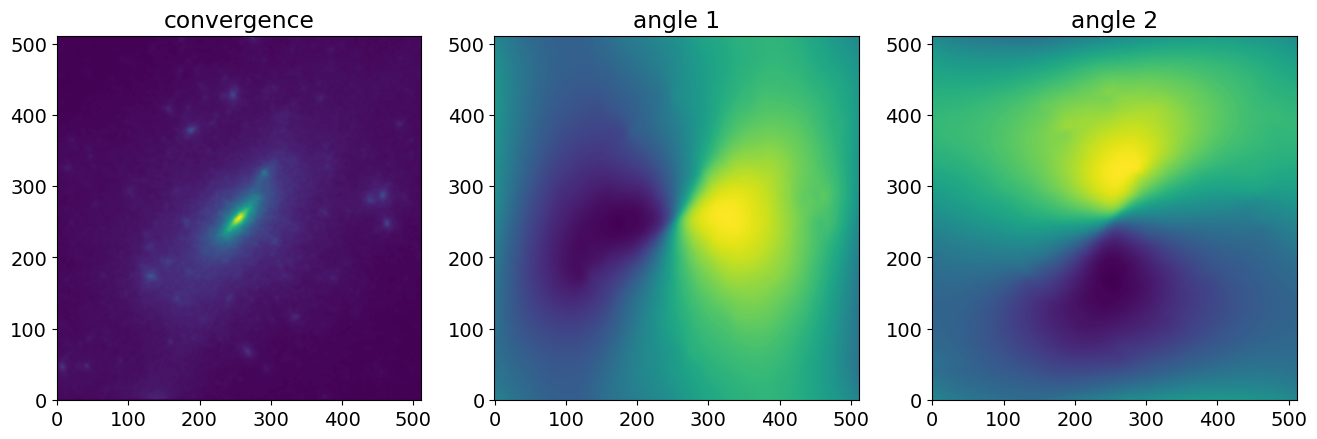

In [4]:
df=deflector('kappa_gl.fits')
angx_nopad,angy_nopad=df.angles()
kappa=df.kmap()

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm, SymLogNorm
%matplotlib inline

#plot the results
font = {'size'   : 14}
import matplotlib
matplotlib.rc('font', **font)

fig,ax = plt.subplots(1,3,figsize=(16,8))
ax[0].imshow(kappa,origin="lower")
ax[0].set_title('convergence')
ax[1].imshow(angx_nopad,origin="lower")
ax[1].set_title('angle 1')
ax[2].imshow(angy_nopad,origin="lower")
ax[2].set_title('angle 2')
fig.savefig('no_padding.png')

Note that at this point we have not yet used the zero-padding trick. FFT assumes periodic boundaries conditions, meaning that the lens mass distribution is replicated outside the boundaries. Given that the region around the lens considered in this example is relatively small, we expect that the deflection angles will be biased near the borders.  
The three panels in the figure above show the maps of the convergence and of the two components of the deflection angles obtained with this setting.

Zero-padding consists of placing zeros all around the convergence map. By doing so, we double the size of the original  map, but we expect to increase the accuracy of the calculations near the borders, beacause the periodic conditions are better reproduced in this setting. We activate zero-padding by just setting the variable ```pad=True``` when initializing the deflector. The figure below shows the zero-padded convergence map and the two new maps of the deflection angle components.  

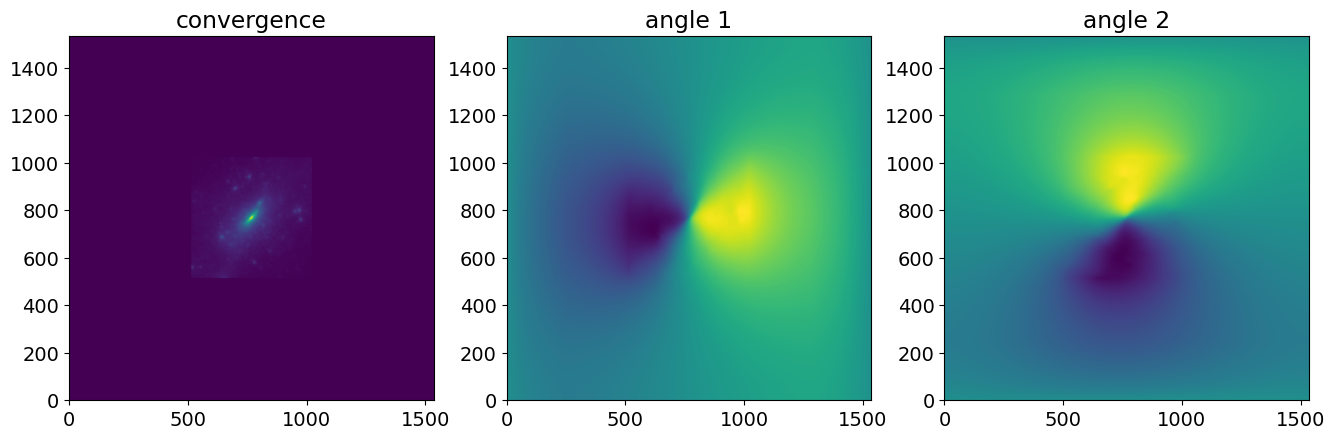

In [5]:
df=deflector('kappa_gl.fits',True)
angx,angy=df.angles()
kappa=df.kmap()

fig,ax = plt.subplots(1,3,figsize=(16,8))
angx,angy=df.angles()
ax[0].imshow(kappa,origin="lower")
ax[0].set_title('convergence')
ax[1].imshow(angx,origin="lower")
ax[1].set_title('angle 1')
ax[2].imshow(angy,origin="lower")
ax[2].set_title('angle 2')
fig.savefig('padding.png')

We are not interested in this large area, thus we can get rid of the values outside the lens convergence map by cropping the deflection angle maps. The results are shown below and compared to the previous ones. In fact, significant differences are visible along the borders.

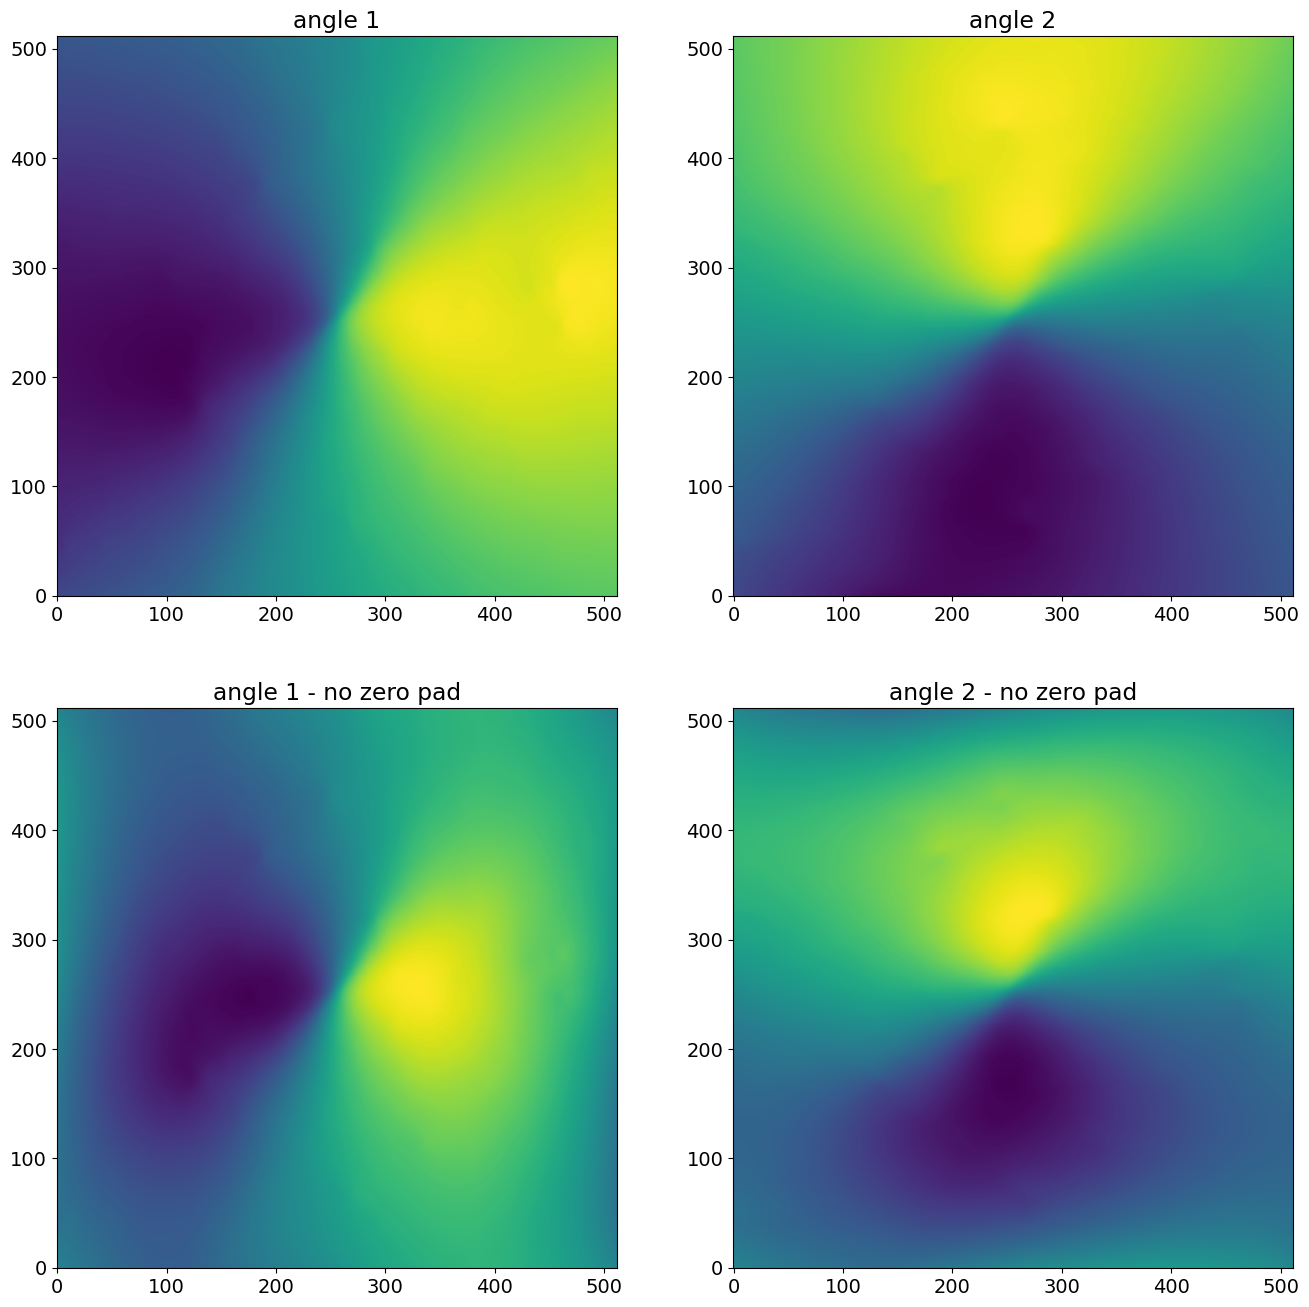

In [6]:
angx=df.mapCrop(angx)
angy=df.mapCrop(angy)

fig,ax = plt.subplots(2,2,figsize=(16,16))
ax[0,0].imshow(angx,origin="lower")
ax[0,0].set_title('angle 1')
ax[0,1].imshow(angy,origin="lower")
ax[0,1].set_title('angle 2')
ax[1,0].imshow(angx_nopad,origin="lower")
ax[1,0].set_title('angle 1 - no zero pad')
ax[1,1].imshow(angy_nopad,origin="lower")
ax[1,1].set_title('angle 2 - no zero pad')
fig.savefig('padding_cropped.png')

# Ray-tracing

In this exercise, we will implement a simple ray-tracing algorithm. In ray-tracing, we make use of the lens equation to propagate a bundle of light-rays from the observer position, through a regular grid covering the lens plane, to the source plane. For each ray passing through the position $\vec x^{ij}$, we will evaluate the deflection angle $\vec\alpha(\vec x^{ij})$ and compute the arrival position on the source plane as
$$
\vec y^{ij}=\vec x^{ij}-\vec{\alpha}(\vec x^{ij}) \;.
$$
In the formula above, $(i,j)$ identify the ray passing through the grid point with indexes $i$ and $j$ along the $x_1$ and $x_2$ axes, respectively.

The deflector used in this example is the same of the previous exercise. In particular, we will use the deflection angle maps shown in the upper panels of the figure above to propagate the light rays towards the sources.

## Creating a mesh on the lens plane

We start by creating a mesh, where each grid-point has two coordinates. Suppose coordinates along the $x_1$ and $x_2$ axes are represented by the $n_{pix}$-dimensional vectors  $|x_1^{i}|$ and $|x_2^j|$, with $i,j\in [1,n_{pix}]$ (so that $n_{pix}$ is the number of grid points along one axis on the mesh). The mesh can be created using the ```numpy.meshgrid``` method, as e.g.



In [7]:
npix=angx.shape[0]
x1=np.linspace(0.0,1.0,npix)*(npix-1) # define x1 coordinates
x2=np.linspace(0.0,1.0,npix)*(npix-1) # define x2 coordinates
x1_,x2_=np.meshgrid(x1,x2) # lens plane mesh
x2_[:,0]

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

This will generate two numpy arrays, ```x1_``` and ```x2_```, with size $n_{pix} \times n_{pix}$. In the first, the values on the $i-$th column will be equal to $x_1^{i}$; in the second, the values on the $j-$th row will be equal to $x_2^{j}$.

## Compute the arrival positions of each ray on the source plane

We may now implement the lens equation for the two components along $x_1$ and $x_2$:

(0.0, 511.0)

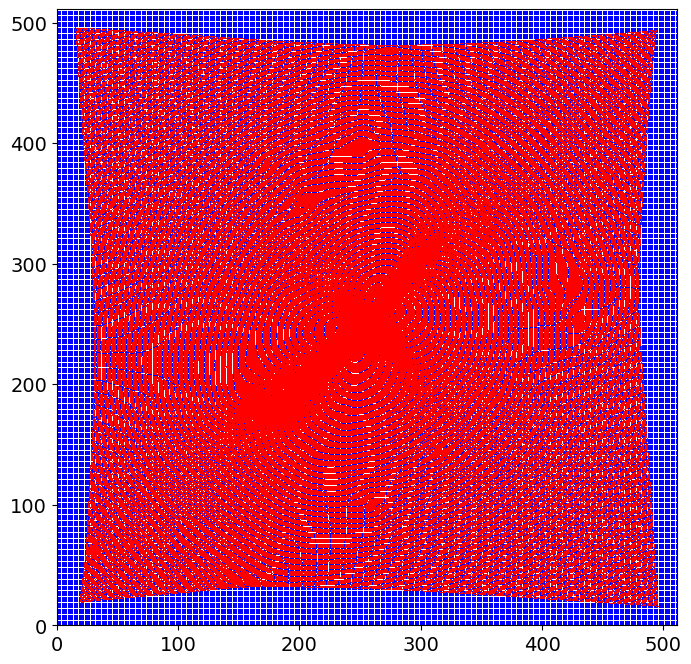

In [8]:
y1=x1_-angx
y2=x2_-angy

#plot the results
fig,ax=plt.subplots(1,1,figsize=(8,8))
ax.plot(np.reshape(x1_,x1_.size),np.reshape(x2_,x2_.size),',',color='blue')
ax.plot(np.reshape(y1,y1.size),np.reshape(y2,y2.size),',',color='red')
ax.set_xlim([0,npix-1])
ax.set_ylim([0,npix-1])

### Alternative approaches: broadcasting, loops

In fact, we could arrive to the same result by using a feature in numpy called *broadcasting*. The term broadcasting describes how numpy treats arrays with different shapes during arithmetic operations. Subject to certain constraints, the smaller array is “broadcast” across the larger array so that they have compatible shapes.

Using this feature, we can write the first component of the lens equation as
$$\left[ \begin{array}{ccc}
y_1^{1,1} & \cdots & y_1^{1,n_{pix}}  \\
\vdots & \ddots & \vdots \\
y_1^{n_{pix},1} & \cdots & y_1^{n_{pix},n_{pix}}   
\end{array} \right]
=B(n_{pix},n_{pix})
\left[ \begin{array}{ccc}
x_1^1 \\
\vdots\\
x_1^{n_{pix}}
\end{array} \right]
-
\left[ \begin{array}{ccc}
\alpha_1^{1,1} & \cdots & \alpha_1^{1,n_{pix}}  \\
\vdots & \ddots & \vdots \\
\alpha_1^{n_{pix},1} & \cdots & \alpha_1^{n_{pix},n_{pix}}
\end{array} \right]
$$

The vector ```x_1``` is then broadcast to match the size of ```alpha_1``` (the broadcasting function is here indicated as $B(n_{pix},n_{pix})$). The result will be to add  $|x_1^i|$ to each column of the matrix $-|\alpha_1^{ij}|$.

Computing the coordinates $|y_2^{ij}|$ involves few more steps. Again, using the lens equation, we obtain:
$$\left[ \begin{array}{ccc}
y_1^{1,1} & \cdots & y_1^{n_{pix},1}  \\
\vdots & \ddots & \vdots \\
y_1^{1,n_{pix}} & \cdots & y_1^{n_{pix},n_{pix}}   
\end{array} \right]
=B(n_{pix},n_{pix})
\left[ \begin{array}{ccc}
x_2^1 \\
\vdots\\
x_2^{n_{pix}}
\end{array} \right]
-
\left[ \begin{array}{ccc}
\alpha_1^{1,1} & \cdots & \alpha_1^{n_{pix},1}  \\
\vdots & \ddots & \vdots \\
\alpha_1^{1,n_{pix}} & \cdots & \alpha_1^{n_{pix},n_{pix}}
\end{array} \right]
$$

This equation implements the column-wise addition of $|x_2^i|$ to  $-|\alpha_2^{ji}|=|\alpha_2^{ij}|^T$, where $T$ indicates the transposed matrix. The result is $|y_2^{ji}|=|y_2^{ij}|^T$.

The python implementation is quite easy:

(0.0, 511.0)

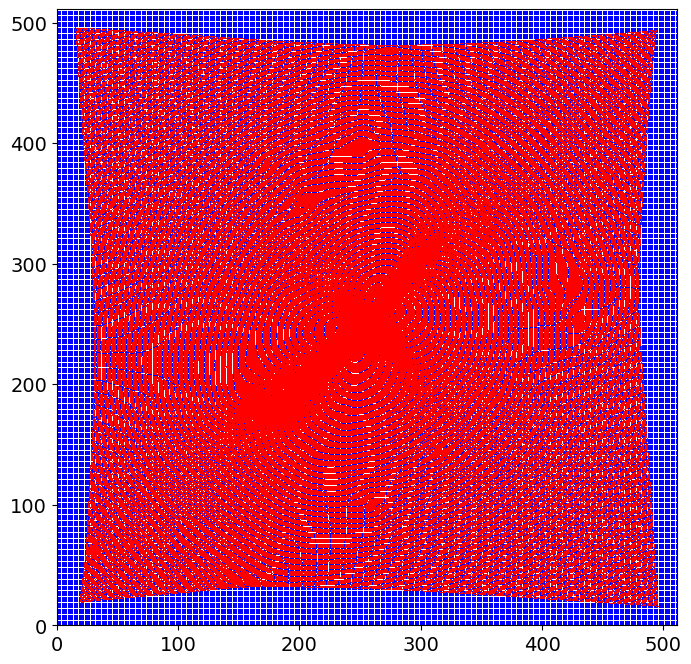

In [9]:
# ray-tracing:
y1=(x1-angx) # y1 coordinates on the source plane
y2=np.transpose(x2-np.transpose(angy)) # y2 coordinates on the source plane

#plot the results
fig,ax=plt.subplots(1,1,figsize=(8,8))
ax.plot(np.reshape(x1_,x1_.size),np.reshape(x2_,x2_.size),',',color='blue')
ax.plot(np.reshape(y1,y1.size),np.reshape(y2,y2.size),',',color='red')
ax.set_xlim([0,npix-1])
ax.set_ylim([0,npix-1])


We can check which implementation is more efficient in terms of computational time by using the magic function ```%timeit```:

In [10]:
%timeit -n 100 y1=x1_-angx
%timeit -n 100 y1=(x1-angx)
%timeit -n 100 y2=x2_-angy
%timeit -n 100 y2=np.transpose(x2-np.transpose(angy))

1.1 ms ± 34.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
412 µs ± 11.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.12 ms ± 75.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
456 µs ± 19.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We can do something similar to check memory usage:

In [11]:
!pip install memory_profiler
%load_ext memory_profiler
%memit -r 10 y1=x1_-angx
%memit -r 10 y1=(x1-angx)
%memit -r 10 y2=x2_-angy
%memit -r 10 y2=np.transpose(x2-np.transpose(angy))

peak memory: 366.29 MiB, increment: 0.38 MiB
peak memory: 366.33 MiB, increment: 0.04 MiB
peak memory: 366.52 MiB, increment: 0.19 MiB
peak memory: 366.52 MiB, increment: 0.00 MiB


As we can see, the performace in the two implementations is very similar. What you should definitely avoid to do is using loops to perform the matrix operations above:

In [12]:
def ray_trace_x1(x1_,angx):
    y1=np.zeros(x1_.shape)
    for i in range(npix):
        for j in range(npix):
            y1[i,j]=x1_[i,j]-angx[i,j]
    return(y1)

%timeit -n 100 y1=ray_trace_x1(x1_,angx)

154 ms ± 39.6 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


**Loops are very inefficient and should be avoided whenever it is possible. The above codes performs the same matrix subtraction discussed in the previous examples $\sim 250$ times slower than seen earlier**

## Downsampling the grid

Let's try to downsample the grid by a factor of 16 on both sides. In this case, we have to interpolate the maps of the deflection angles at a reduced number of positions compared to the original map:

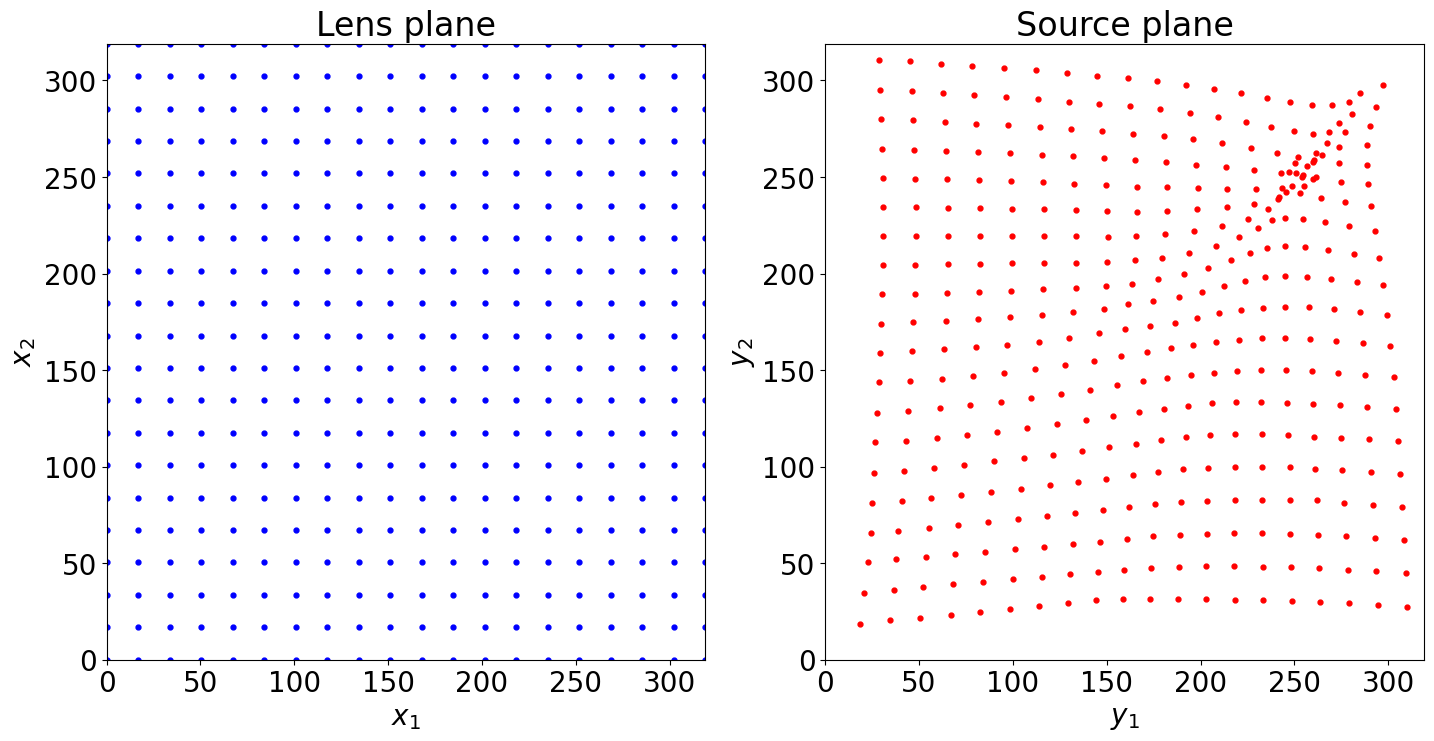

In [13]:
import numpy as np
from scipy.ndimage import map_coordinates
import matplotlib.pyplot as plt

# Assuming npix is defined, for example:
npix = 320  # example value, adjust as needed
ndown = 16

# Use integer division for npix/ndown
x1 = np.linspace(0.0, 1.0, npix // ndown) * (npix - 1)
x2 = np.linspace(0.0, 1.0, npix // ndown) * (npix - 1)

x1_, x2_ = np.meshgrid(x1, x2)

# Assuming angx and angy are defined, for example:
# angx = np.random.rand(npix, npix)  # example initialization, adjust as needed
# angy = np.random.rand(npix, npix)  # example initialization, adjust as needed

x = np.reshape(x1_, x1_.size)
y = np.reshape(x2_, x2_.size)

# Interpolate:
angx_ = map_coordinates(angx, [y, x], order=1) #linear interpolation at [y, x] position on lens plane
angy_ = map_coordinates(angy, [y, x], order=1) #linear interpolation at [y, x] position on lens plane


# Reshape using integer division for npix/ndown
angx_ = angx_.reshape((npix // ndown, npix // ndown))
angy_ = angy_.reshape((npix // ndown, npix // ndown))

y1 = x1_ - angx_
y2 = x2_ - angy_

# Plotting setup
font = {'weight': 'normal', 'size': 20}
matplotlib.rc('font', **font)

fig, ax = plt.subplots(1, 2, figsize=(17, 8))
ax[0].plot(np.reshape(x1_, x2_.size), np.reshape(x2_, x2_.size), 'o', color='blue', markersize=3.5)
ax[1].plot(np.reshape(y1, y1.size), np.reshape(y2, y2.size), 'o', color='red', markersize=3.5)
ax[0].set_title('Lens plane')
ax[1].set_title('Source plane')
ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('$x_2$')
ax[1].set_xlabel('$y_1$')
ax[1].set_ylabel('$y_2$')

for i in [0, 1]:
    ax[i].set_xlim([0, npix - 1])
    ax[i].set_ylim([0, npix - 1])

fig.savefig('raytracing.png')


# Lensing potential

Deriving the lensing potential from the lens convergence map requires to solve the Poisson equation in two dimensions:
$$
\kappa(\vec x) = \frac{1}{2}\triangle \Psi
$$
This can be done numerically by means of Fast-Fourier-Transform.

The Fourier transform of the Laplace operator is
$$
\tilde{\triangle}(\vec k)=-4\pi^2 k^2
$$
where $k^2=k_1^2+k_2^2$.
Therefore, in Fourier space, the Poisson equation reads
$$
-4\pi^2k^2\tilde\Psi(\vec k)=2\tilde\kappa(\vec k) \;.
$$
The Fourier transform of the lensing potential is then
$$
\tilde\Psi(\vec k)=-\frac{\tilde\kappa(\vec k)}{2\pi^2k^2} \;.
$$

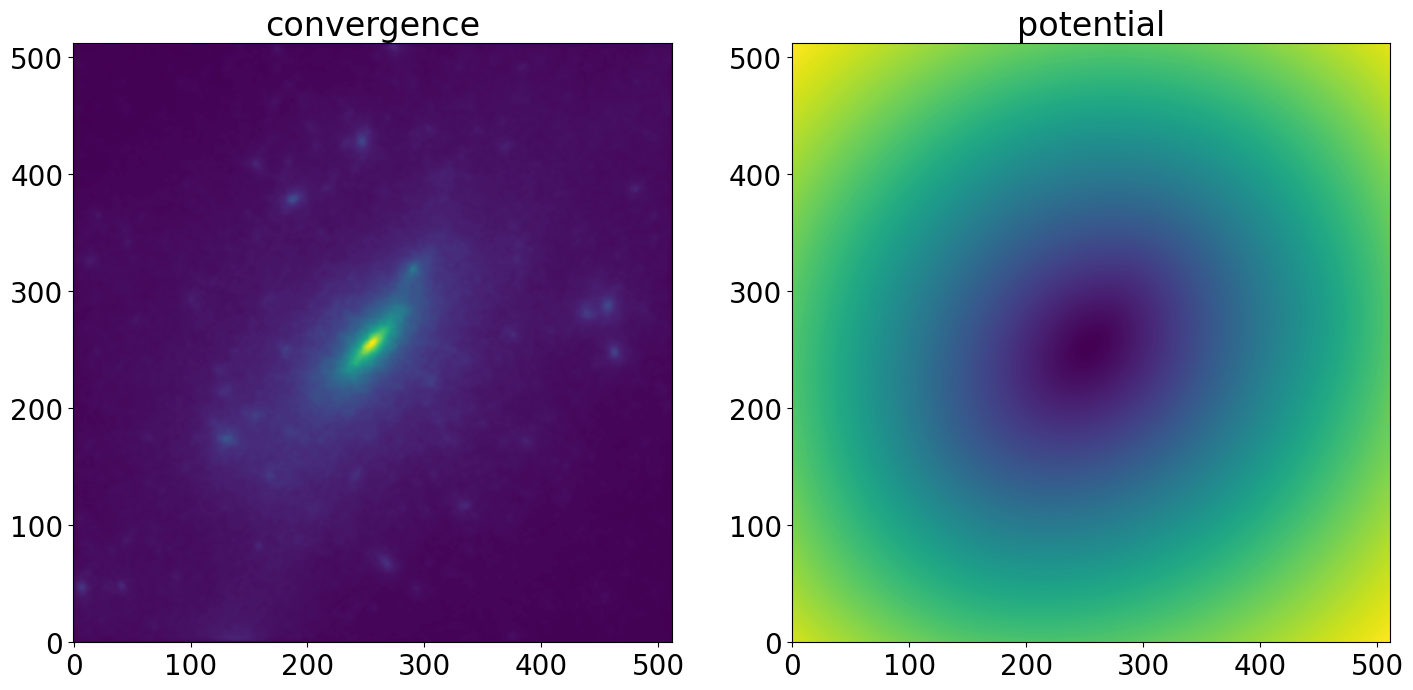

In [14]:
pot=df.potential()
kappa=df.mapCrop(kappa)
pot=df.mapCrop(pot)

fig,ax = plt.subplots(1,2,figsize=(17,8))
ax[0].imshow(kappa,origin="lower")
ax[0].set_title('convergence')
ax[1].imshow(pot,origin="lower")
ax[1].set_title('potential')
fig.savefig('potential.png')

## 3..7.3 Lensing Maps

Once the potential is known, it is easy to compute maps of many other lenses’
properties. For example, the gradient of psi is the deflection angle. Thus, we can
implement a method to compute α vector, which is an alternative to that discussed in Sect. 2.5.2.

We use the numpy.gradient method to calculate the gradient using finite differences
on the grids. The maps of the deflection angle components α1 and α2
are obtained as follows:

In [15]:
a2,a1=np.gradient(pot)

Note that, because of the axis convention in python, the derivatives of psi along the
second dimension is given first. We do not display the maps, as they are analogous
to those shown e.g. in Fig. 2.6.
By computing further gradients

By computing further gradients of these maps, we obtain the second derivatives
of the potential. By combining them, we can compute the convergence (which is already known, as it was the input to derive the potential) and the shear components.
The python implementation of Eq. 3.36 is as follows:

In [16]:
# First we compute the second derivatives of pot
psi12,psi11=np.gradient(a1)
psi22,psi21=np.gradient(a2)
# Then we combine them to form the first and the second component of
# the shear tensor
gamma1=0.5*(psi11-psi22)
gamma2=psi12

In Fig. 3.14, we show the maps both γ1 and γ2

The direction of the axes of the ellipse
is given by the angle φ in Eq. 3.43, which can be computed using the arctan2
function:

In [17]:
phi=np.arctan2(gamma2,gamma1)/2.0

Note that we have to divide by 2 in order to account for the fact that γ is a spin-2
tensor. It is interesting to display the direction into which the shear distorts images
and compare it to lens mass distribution. Figure 3.15 shows the direction of the shear
using sticks overlaid to the lens convergence. The code to produce the figure is

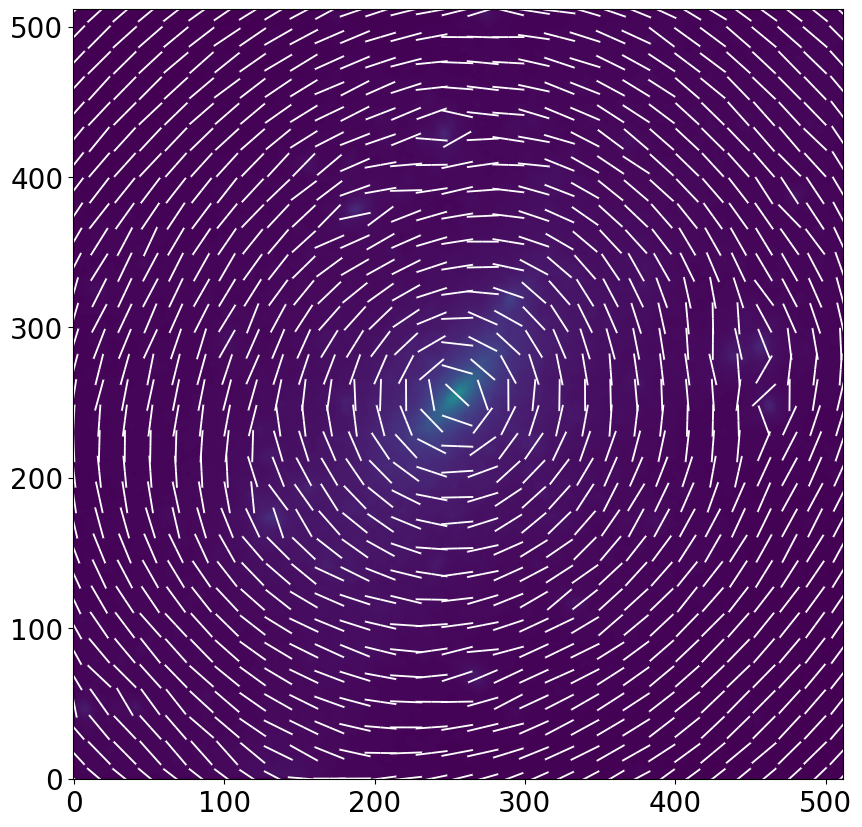

In [18]:
# Convert pixel_step to an integer to ensure grid points are integers
pixel_step = int(gamma1.shape[1] / 32) + 1
x, y = np.meshgrid(np.arange(0, gamma1.shape[1], pixel_step), np.arange(0, gamma1.shape[0], pixel_step))

# Create a figure and an axes instance
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Display the image
ax.imshow(kappa, origin='lower', vmax=3)

# Ensure x and y are used as integer indices
x_indices = x.astype(int)
y_indices = y.astype(int)

# Quiver plot for showing the orientation of the shear in opposite directions
ax.quiver(y, x, np.cos(phi[x_indices, y_indices]), np.sin(phi[x_indices, y_indices]), headwidth=0, units="height", scale=x.shape[0], color="white")
ax.quiver(y, x, -np.cos(phi[x_indices, y_indices]), -np.sin(phi[x_indices, y_indices]), headwidth=0, units="height", scale=x.shape[0], color="white")

plt.show()


From the maps of the shear, we can derive the maps of the flexions F and G. Each
of these quantities has two components, corresponding to the real and to imaginary
parts of the complex quantities in Eqs. 3.73 and 3.74:

In [19]:
gamma12,gamma11=np.gradient(gamma1)
gamma22,gamma21=np.gradient(gamma2)
F1,F2=gamma11+gamma22,gamma21-gamma12
G1,G2=gamma11-gamma22,gamma21+gamma12

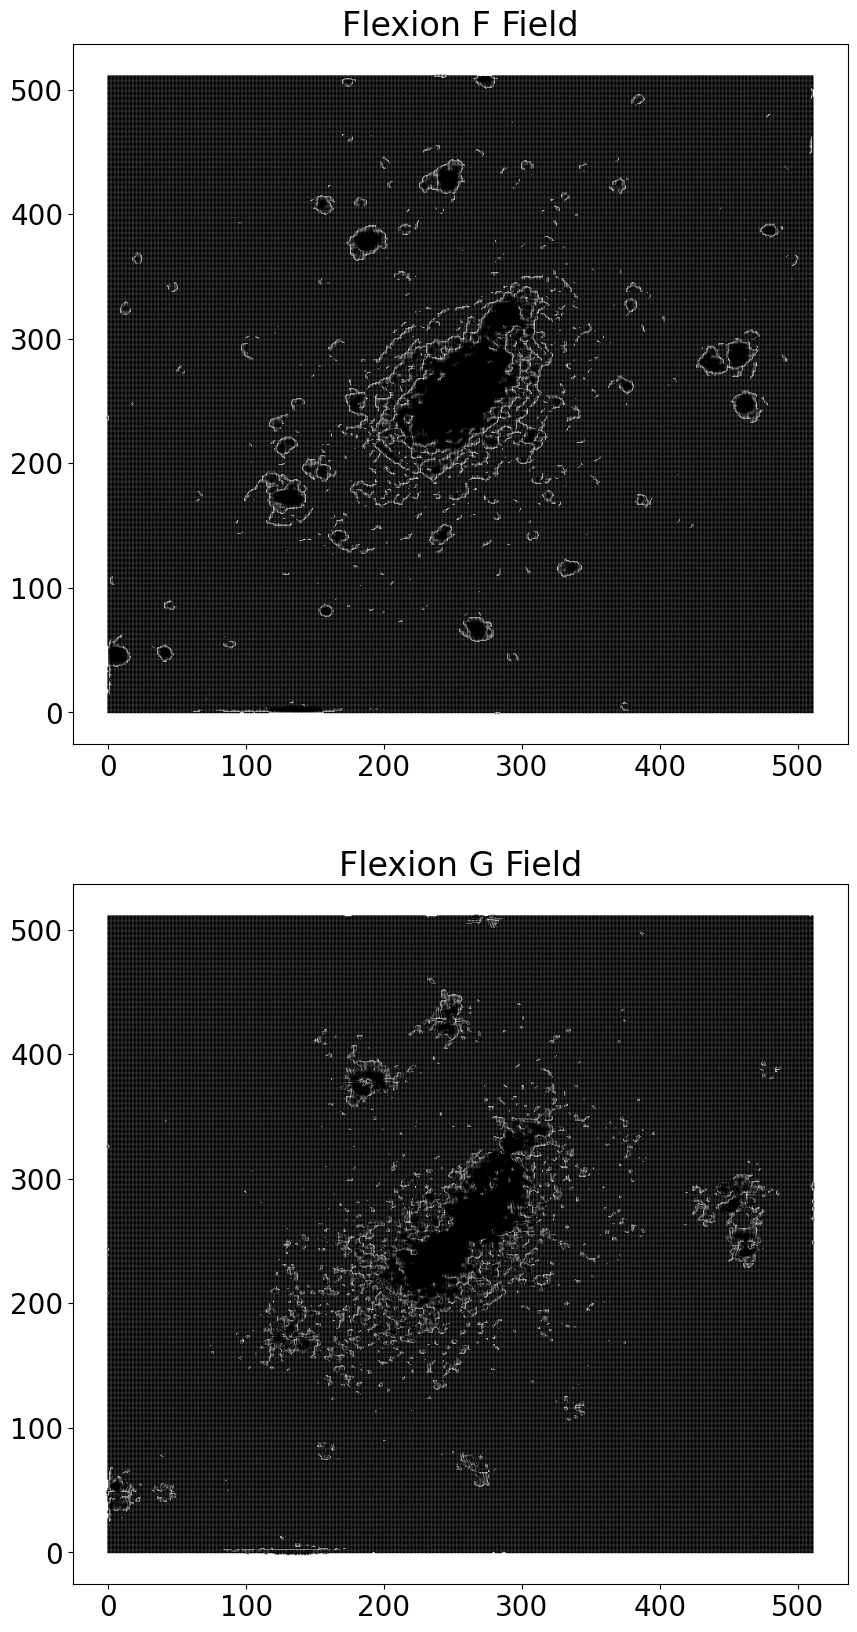

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `gamma1` and `gamma2` are defined. Compute gradients.
gamma12, gamma11 = np.gradient(gamma1)
gamma22, gamma21 = np.gradient(gamma2)

# Compute Flexions
F1, F2 = gamma11 + gamma22, gamma21 - gamma12
G1, G2 = gamma11 - gamma22, gamma21 + gamma12

# Set up a grid for quiver plots
x, y = np.meshgrid(np.arange(0, F1.shape[1]), np.arange(0, F1.shape[0]))

# Create a figure and axis objects for subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 20))

# Quiver plot for F
axs[0].quiver(x, y, F1, F2)
axs[0].set_title('Flexion F Field')

# Quiver plot for G
axs[1].quiver(x, y, G1, G2)
axs[1].set_title('Flexion G Field')

plt.show()

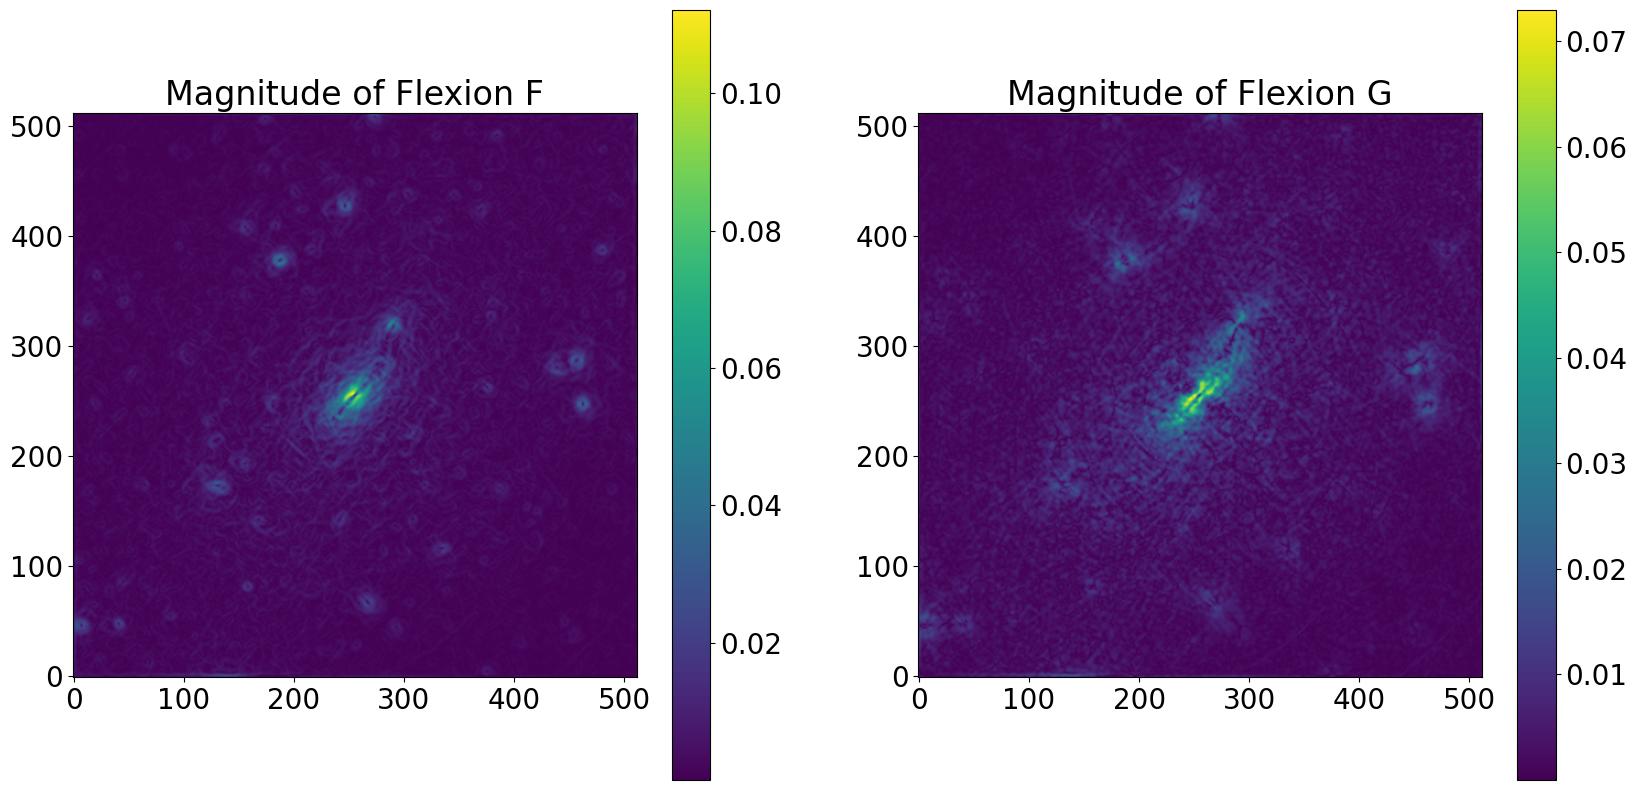

In [21]:
# Compute magnitudes of F and G
F_magnitude = np.sqrt(F1**2 + F2**2)
G_magnitude = np.sqrt(G1**2 + G2**2)

# Create a figure and axis objects for subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Image plot for magnitude of F
img1 = axs[0].imshow(F_magnitude, origin='lower', cmap='viridis')
fig.colorbar(img1, ax=axs[0])
axs[0].set_title('Magnitude of Flexion F')

# Image plot for magnitude of G
img2 = axs[1].imshow(G_magnitude, origin='lower', cmap='viridis')
fig.colorbar(img2, ax=axs[1])
axs[1].set_title('Magnitude of Flexion G')

plt.show()

## Critical Lines and Caustics

There are several methods to identify the points belonging to the critical lines. A
simple way to visualize them is drawing the zero-level contours in the maps of
λt and λr . For example, to visualize the critical lines of the lens in the previous
examples, we can do as follows:

Text(0.5, 1.0, '$\\det A$')

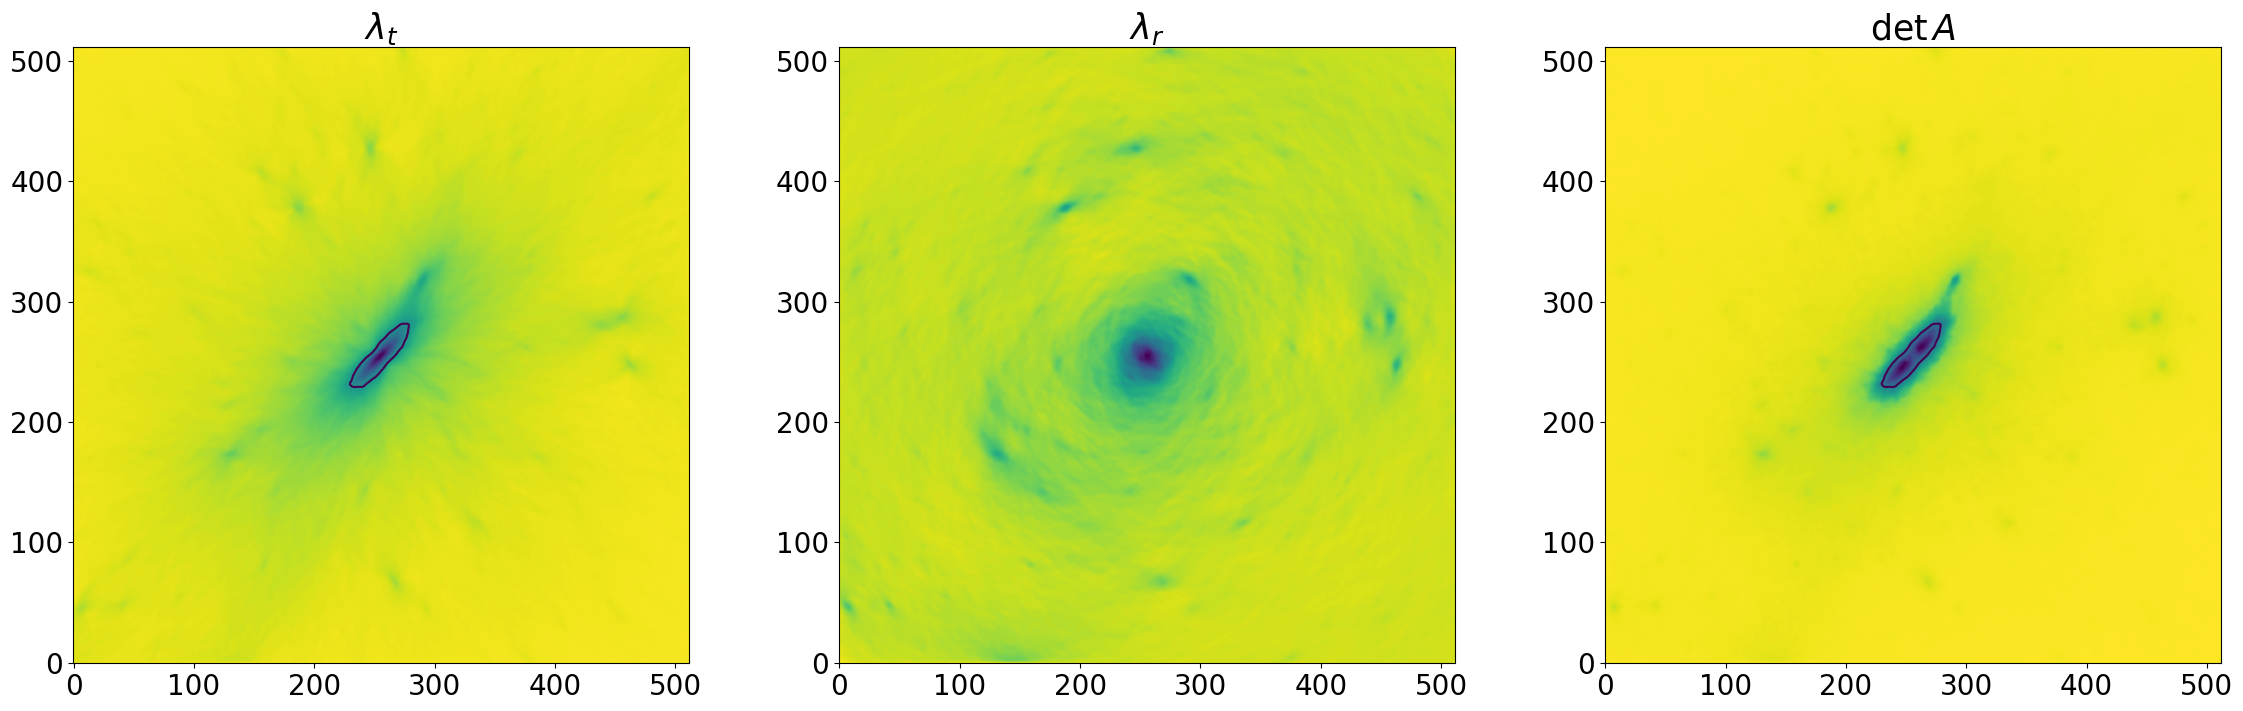

In [22]:
from matplotlib.colors import SymLogNorm
gamma=np.sqrt(gamma1**2+gamma2**2)
lambdat=1.0-kappa-gamma
lambdar=1.0-kappa+gamma
detA=lambdat*lambdar
fig,ax=plt.subplots(1,3,figsize=(28,8))
ax[0].imshow(lambdat,origin='lower')
ax[0].contour(lambdat,levels=[0.0])
ax[0].set_title('$\lambda_t$',fontsize=25)
ax[1].imshow(lambdar,origin='lower')
ax[1].contour(lambdar,levels=[0.0])
ax[1].set_title('$\lambda_r$',fontsize=25)
ax[2].imshow(detA,origin='lower',norm=SymLogNorm(0.3))
ax[2].contour(detA,levels=[0.0])
ax[2].set_title('$\det A$',fontsize=25)

We display the results in Fig. 3.17. The left and the central panels show the maps
of λt and λr , respectively. In the right panel, we show the map of detA. In all panels,
we also show the maps’ zero-level contours, i.e. the critical lines. In the left and
the central panels, the tangential and the radial critical lines are shown separately,
while in the right panel, they are displayed simultaneously. Note that these are the
critical lines for a specific source redshift. The convergence map used to compute
the lensing potential is calculated for zs_norm = 9. To obtain the critical lines for different source redshift zs , we need to re-scale both κ and γ by the distance ratio

Equation 3.96

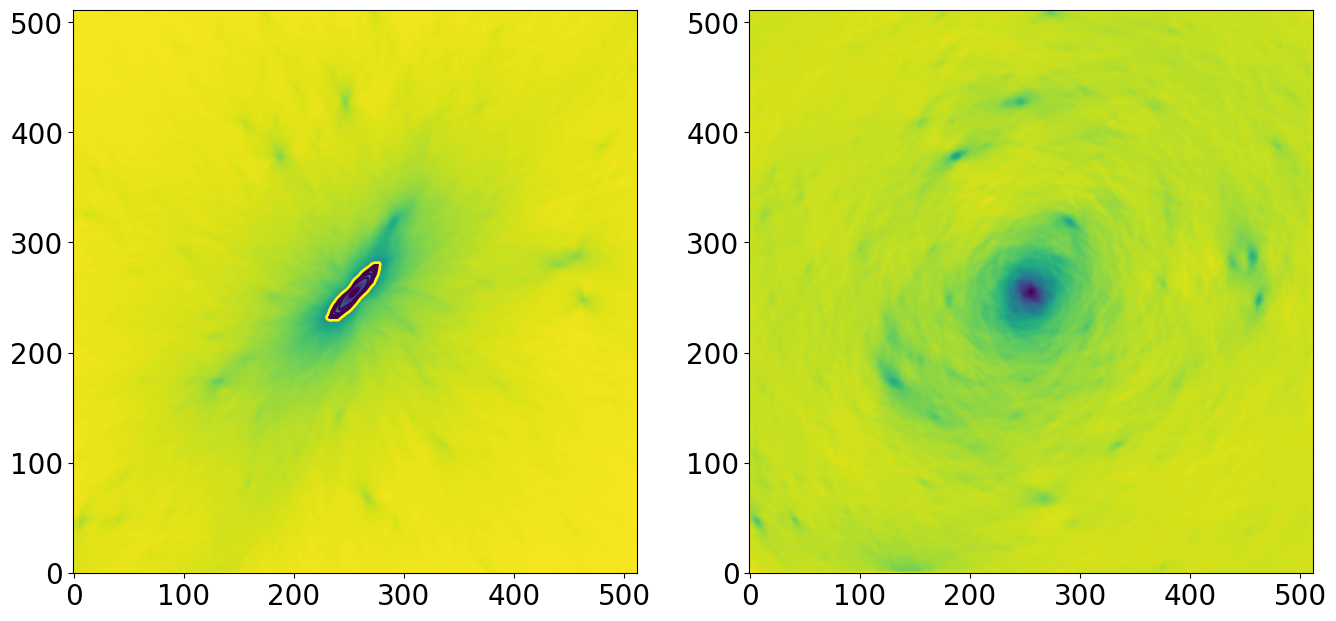

In [23]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

zl=0.5
zs_norm=9.0

zs=np.linspace(zl,10.0,20)
dl=cosmo.angular_diameter_distance(zl)
ds=cosmo.angular_diameter_distance(zs)
dls=[]
for i in range(ds.size):
    dls.append(cosmo.angular_diameter_distance_z1z2(zl,zs[i]).value)

ds_norm=cosmo.angular_diameter_distance(zs_norm)
dls_norm=cosmo.angular_diameter_distance_z1z2(zl,zs_norm)

fig,ax=plt.subplots(1,2,figsize=(16,8))
ax[0].imshow(lambdat,origin='lower')
ax[1].imshow(lambdar,origin='lower')
for i in range(ds.size):
    kappa_new=kappa*ds_norm.value/dls_norm.value*dls[i]/ds[i].value
    gamma_new=gamma*ds_norm.value/dls_norm.value*dls[i]/ds[i].value
    lambdat_new=(1.0-kappa_new-gamma_new)
    lambdar_new=(1.0-kappa_new+gamma_new)
    ax[0].contour(lambdat_new,levels=[0.0])
    ax[1].contour(lambdar_new,levels=[0.0])

ax[0].contour(lambdat,levels=[0.0],colors="yellow",linewidths=2)
ax[1].contour(lambdar,levels=[0.0],colors="magenta",linewidths=2)

The caustics are the “sources” of the critical lines. In other words, if θc is a point
on the critical lines, then

βc = θc − α(θc)

is the corresponding point on the caustics.


To derive the caustics, we need first to extract the critical points from the
contours described above. Then, we measure the deflection angles at the position
of the critical points, by interpolating them on the maps of the deflection
angles computed earlier. We use again the map_coordinates method from the
scipy.ndimage module. In the following, we work in pixel units:

(0.0, 2048.0)

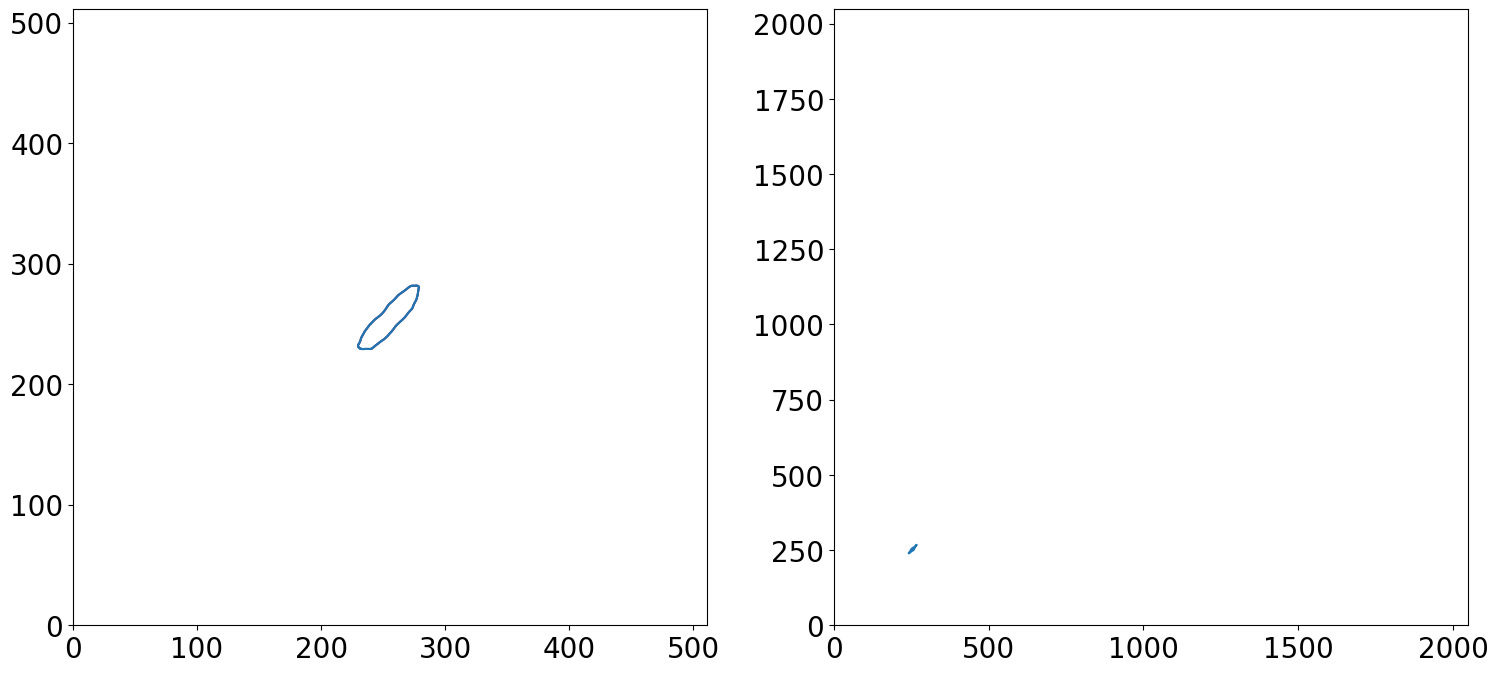

In [24]:
fig,ax=plt.subplots(1,2,figsize=(18,8))
# first, we extract the level-0 contours of the map of detA
cs=ax[0].contour(detA,levels=[0.0])

# then, we take the path of each closed contour
contour=cs.collections[0]
p=contour.get_paths() # p contains the paths of each individual
# critical line

sizevs=np.empty(len(p),dtype=int)
from scipy.ndimage import map_coordinates
# if we find any critical line, then we process it
if (sizevs.size > 0):
    for j in range(len(p)):
        # the contours are ensembles of polygons, called paths
        # for each path, we create two vectors containing the x1
        # and x2 coordinates of the vertices
        vs = contour.get_paths()[j].vertices
        sizevs[j]=len(vs)
        x1=[]
        x2=[]
        for i in range(len(vs)):
                xx1,xx2=vs[i]
                x1.append(float(xx1))
                x2.append(float(xx2))
        # these are the points we want to map back on the source plane.
        # To do that we need to evaluate the deflection angle at their
        # positions using scipy.ndimage.interpolate.map_coordinates
        # we perform a bi-linear interpolation

        a_1=map_coordinates(a1, [[x2],[x1]],order=1)
        a_2=map_coordinates(a2, [[x2],[x1]],order=1)

        # now we use the lens equation to
        # obtain the caustics:
        y1=x1-a_1[0]
        y2=x2-a_2[0]

        # plot the results!
        ax[0].plot(x1,x2,'-')
        ax[1].plot(y1,y2,'-')

ax[1].set_xlim([0,2048])
ax[1].set_ylim([0,2048])

The left and right panels in Fig. 3.19 show the lens critical lines and the caustics,
respectively.We compare the shape of the caustics to the pattern visible in the right
panel of Fig. 3.12. Performing ray-tracing, we found that starting from a regular grid
of ray positions on the lens plane, we end up with an irregular grid on the source
plane, which also covers a smaller area of the sky due to magnification. We can
easily see that the arrival positions of light rays on the source plane cluster around
the lens’s caustics.